Configurações iniciais

In [25]:
#Importação de módulos

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [26]:
# Dados
scaler = StandardScaler()

mnist = load_digits()
X, y = scaler.fit_transform(mnist.data), mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Treinamento do modelo baseado em árvore de decisão

In [27]:
param = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Imprimir a precisão da Decision Tree
print("Precisão:", best_clf.score(X_test, y_test))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Melhores hiperparâmetros: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Precisão: 0.8462962962962963


Avaliação dos ganhos com a utilização de modelos Ensemble

In [43]:
#Modelos
ada_clf = AdaBoostClassifier(algorithm='SAMME',random_state=42)
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

#Enseble
voting_clf = VotingClassifier(
    estimators=[
        ('ada', ada_clf),
        ('xgb', xgb_clf),
        ('rf', rf_clf)
    ],
    voting='hard'
)

#Parametros
param_grid = {
    'ada__n_estimators': [5, 10],
    'xgb__n_estimators': [10, 50],
    'xgb__learning_rate': [0.1, 0.3, 0.5],
    'rf__n_estimators': [10, 50],
    'xgb__max_depth': [3, 5],
    'rf__max_depth': [None, 10],
    'rf__min_samples_split': [2, 5, 10]
}

#GridSearch
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy',verbose=10)
grid_search.fit(X_train, y_train)

#Melhores parametros
print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Ensemble model: {accuracy:.4f}')


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5; 1/288] START ada__n_estimators=5, rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=10, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=10
[CV 1/5; 1/288] END ada__n_estimators=5, rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=10, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=10;, score=0.921 total time=   0.1s
[CV 2/5; 1/288] START ada__n_estimators=5, rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=10, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=10
[CV 2/5; 1/288] END ada__n_estimators=5, rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=10, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=10;, score=0.877 total time=   0.1s
[CV 3/5; 1/288] START ada__n_estimators=5, rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=10, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=10
[CV 3/5; 1/288

/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'ada__n_estimators': 5, 'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 50, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Accuracy of Ensemble model: 0.9704


In [45]:
from PIL import Image

img = Image.open('images/5.png')
img_array = np.array(img)
img_array = np.dot(img_array[...,:3], [0.2989, 0.5870, 0.1140])
img_array = img_array.reshape(1, -1)


prediction = best_model.predict(img_array)
print(prediction)

[1]


Visualização da árvore de decisão e Medida de Impureza

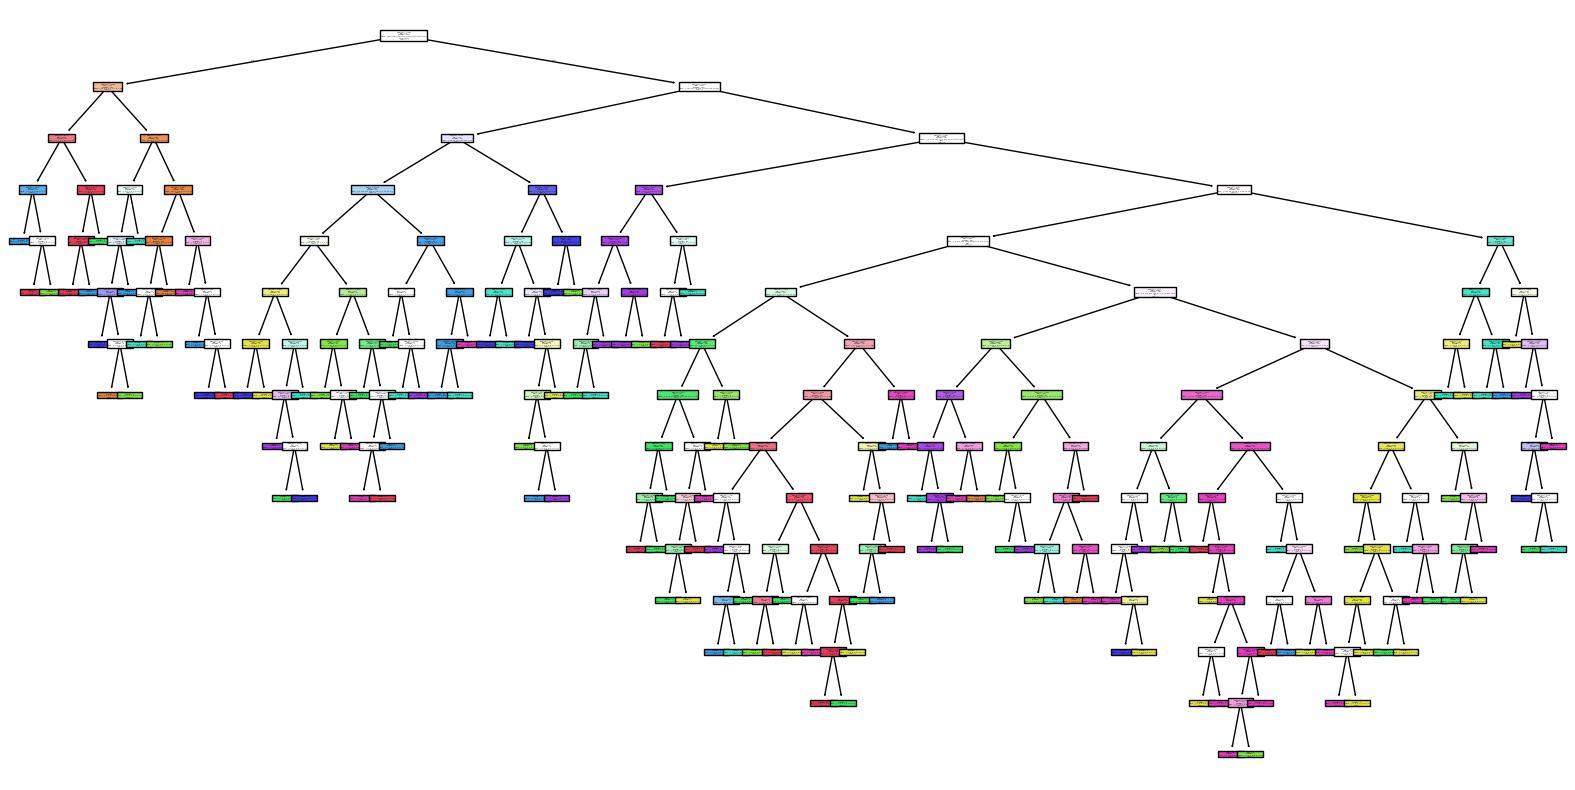

In [54]:
plt.figure(figsize=(20,10))
plot_tree(best_clf, filled=True, feature_names=[f'pixel_{i}' for i in range(X.shape[1])], class_names=[str(i) for i in range(10)])
plt.show()

In [55]:
# Medidas de impureza

def gini_impurity(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return 1 - np.sum(probabilities ** 2)

def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities))

print(f'Gini Impurity : {gini_impurity(y_pred):.4f}')
print(f'Entropy: {entropy(y_pred):.4f}')

Gini Impurity : 0.8984
Entropy: 3.3105


In [56]:
model_path = 'models/model.pkl'
joblib.dump(best_model, model_path)

['models/model.pkl']